In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import tqdm

import time
import polars as pl

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import torchopt


import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from torch.nn.functional import relu

@dataclass
class Config:
  n_features: int
  n_neurons: int

  # We optimize n_instances models in a single training loop
  # to let us sweep over sparsity or importance curves 
  # efficiently.

  # We could potentially use torch.vmap instead.
  n_instances: int

 
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.W0 = nn.Parameter(torch.empty((config.n_neurons, config.n_features)))
        #self.b0 = nn.Parameter(torch.zeros((config.n_hidden,), device=device))
        
        nn.init.xavier_normal_(self.W0)
        self.W1 = nn.Parameter(torch.empty((config.n_features, config.n_neurons)))
        self.b1 = nn.Parameter(torch.zeros((config.n_features,)))
        nn.init.xavier_normal_(self.W1)
        


    def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
        hidden = torch.einsum('bf,nf->bn', features, self.W0)
        out = torch.einsum('bn,fn->bf', relu(hidden), self.W1) + self.b1
        return relu(out)




class SparseUniformData:

    def __init__(self, n_instances, n_features, importance=None, feature_probability=None, device='cuda:0'):
        self.n_instances = n_instances
        self.n_features = n_features
        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)
        self.device = device
    
    def generate(self, n_batch):
        feat = torch.zeros((self.n_instances, n_batch, self.n_features), device=self.device).squeeze()
        feat.uniform_(-1, 1)
        batch = torch.where(
          torch.rand((self.n_instances, n_batch, self.n_features), device=self.device).squeeze() <= self.feature_probability,
          feat,
          torch.zeros((), device=self.device),
        )
        return batch



In [4]:
from tqdm.notebook import trange

from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model, stream, batch_size=1024, steps=10_000, warmup_steps=1000, print_freq=100, lr=1e-3, hooks=[], ):
    cfg = model.config
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    #warmup = LinearLR(opt, start_factor=0.0001, total_iters=warmup_steps)
    #cosine = CosineAnnealingLR(opt, T_max=(steps-warmup_steps), eta_min=1e-6)
    #lr_scheduler = SequentialLR(opt, [warmup, cosine], milestones=[warmup_steps])
    

    start = time.time()
    with trange(steps) as run:
        for step in run:
            opt.zero_grad(set_to_none=True)
            batch = stream.generate(batch_size)
            out = model(batch)
            error = stream.importance * ((batch.abs() - out)**2)
            loss = error.mean()
            loss.backward()
            opt.step()
            #lr_scheduler.step()
        
            if hooks:
                hook_data = dict(
                    model=model,
                    step=step, 
                    opt=opt,
                    error=error,
                    loss=loss,
                    lr=step_lr
                )
            for h in hooks:
              h(hook_data)
            if step % print_freq == 0 or (step + 1 == steps):
                run.set_postfix(
                    loss=loss.item() / cfg.n_instances,
                    lr=lr,
                )

In [239]:
config = Config(
    n_features = 100,
    n_neurons = 40,
    n_instances = 1,
)

model = Model(
    config=config,
    # Exponential feature importance curve from 1 to 1/100
    #importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
   # feature_probability = torch.tensor(0.9) #(20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

stream = SparseUniformData(
    config.n_instances,
    config.n_features,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = torch.tensor(0.05)   #(20 ** -torch.linspace(0, 1, config.n_instances))[:, None, None]
)

model.to('cuda:0')

#batch = stream.generate(100)
#out = model(batch)

bs = 2 ** 17

optimize(model, stream, batch_size=bs, steps=50_000, lr=0.0001)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [240]:
import polars as pl

dims = list(range(100))

w0_df = (
    pl.DataFrame(model.W0.T.detach().cpu().numpy(), schema=[f'neuron{i}' for i in range(config.n_neurons)])
    .with_row_count()
    .rename({'row_nr': 'feature'})
    #.with_columns((0.9 ** pl.col('feature')).alias('importance'))
)

In [241]:
from plotnine import ggplot, geom_line, aes, facet_wrap, geom_abline

learned_abs_fn = torch.zeros((400, 100))

for i, a in  enumerate(torch.linspace(-3., 3., 400, device='cuda')):
    with torch.no_grad():
        out = torch.diag(model(a * torch.eye(100, device='cuda'))).detach().cpu()
        learned_abs_fn[i, :] = out

learned_abs_fn = torch.concat([torch.linspace(-3, 3, 400)[:, None], learned_abs_fn], dim=1).numpy()
learned_abs_df = pl.DataFrame(learned_abs_fn, schema=['baseline'] + [f'feature{i}' for i in range(100)])

In [310]:
df = learned_abs_df.melt(id_vars='baseline')
(
    df
    .filter(pl.col('baseline').is_in([-3.0, 3.0]))
    .filter(pl.col('value') > 0)
    .group_by('variable')
    .count()
    .filter(
        pl.col('count') > 1
    )
    .sort('variable')
)

variable,count
str,u32
"""feature0""",2
"""feature1""",2
"""feature12""",2
"""feature2""",2
"""feature3""",2
"""feature30""",2
"""feature39""",2
"""feature43""",2
"""feature44""",2


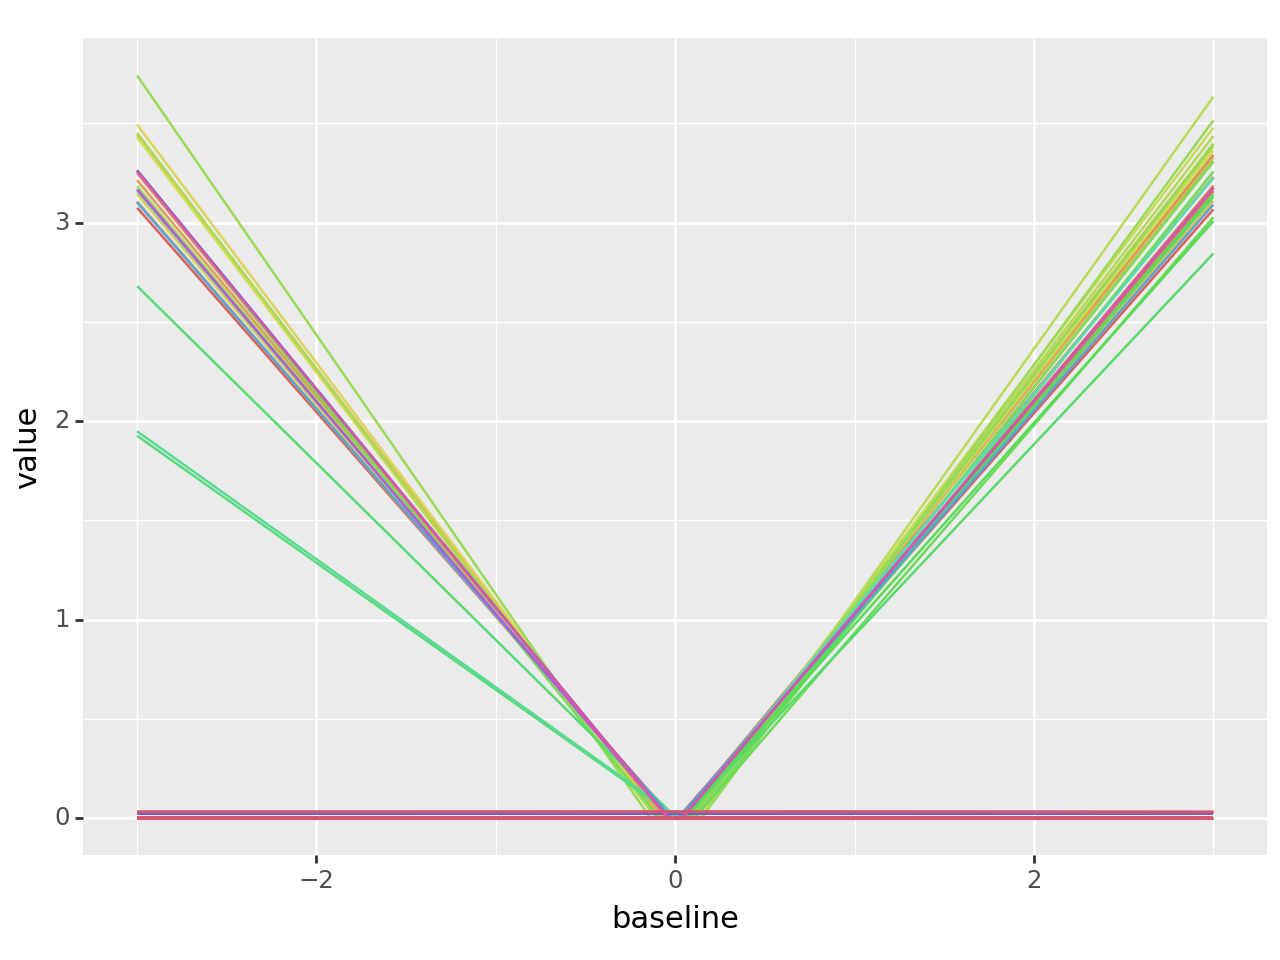

<Figure Size: (640 x 480)>

In [311]:

ggplot(df, aes(x='baseline', y='value', color='variable')) + geom_line(show_legend=False)

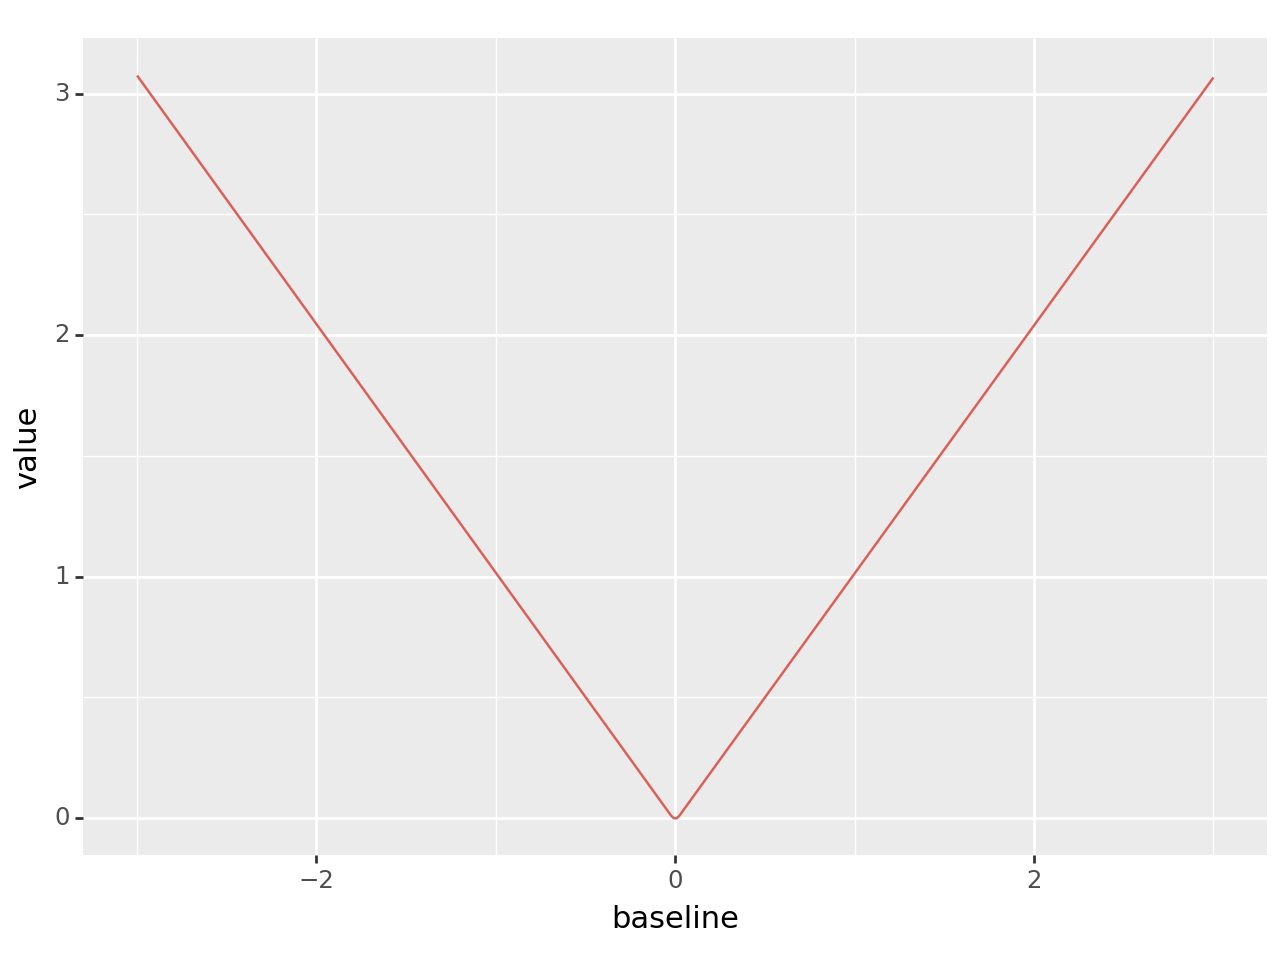

<Figure Size: (640 x 480)>

In [313]:
ggplot(df.filter(pl.col('variable') == 'feature0'), aes(x='baseline', y='value', color='variable')) + geom_line(show_legend=False)

In [251]:
(
    df
    .filter(pl.col('baseline').is_in([-3.0, 3.0]))
    .filter(pl.col('value') > 0)
    .group_by('variable')
    .count()
    .filter(
        pl.col('count') > 1
    )
)

variable,count
str,u32
"""feature43""",2
"""feature64""",2
"""feature12""",2
"""feature30""",2
"""feature57""",2
"""feature44""",2
"""feature1""",2
"""feature2""",2
"""feature65""",2


In [195]:
df

baseline,variable,value
f32,str,f32
-3.0,"""feature0""",3.560843
-2.984962,"""feature0""",3.542427
-2.969925,"""feature0""",3.52401
-2.954887,"""feature0""",3.505593
-2.93985,"""feature0""",3.487177
-2.924812,"""feature0""",3.46876
-2.909775,"""feature0""",3.450344
-2.894737,"""feature0""",3.431926
-2.879699,"""feature0""",3.41351


In [283]:
from plotnine import ggplot, geom_line, aes, facet_wrap, geom_abline

noisy_abs_fn = torch.zeros((400, 100))

for i, a in  enumerate(torch.linspace(-3., 3., 400, device='cuda')):
    with torch.no_grad():
        noise =  (torch.randn((100, 100), device='cuda') * 0.01)
        noise[(tuple(range(100)), tuple(range(100)))] = 0
        x = (a * torch.eye(100, device='cuda')) + noise
        out = torch.diag(model(x)).detach().cpu()
        noisy_abs_fn[i, :] = out

noisy_abs_fn = torch.concat([torch.linspace(-3, 3, 400)[:, None], noisy_abs_fn], dim=1).numpy()
noisy_abs_df = pl.DataFrame(noisy_abs_fn, schema=['baseline'] + [f'feature{i}' for i in range(100)])


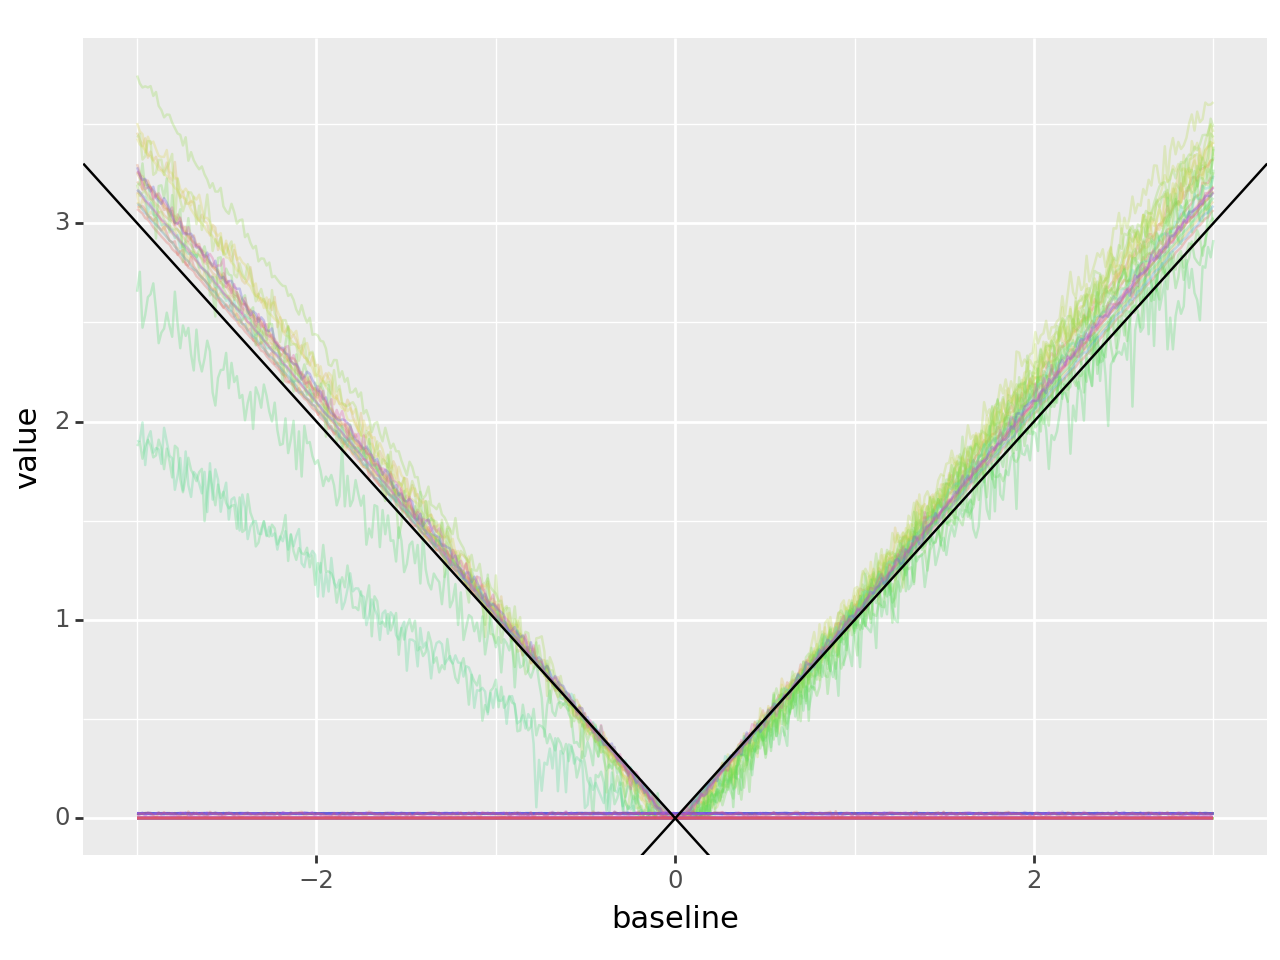

<Figure Size: (640 x 480)>

In [284]:
df = noisy_abs_df.melt(id_vars='baseline')
(
    ggplot(df, aes(x='baseline', y='value', color='variable')) 
    + geom_line(alpha=0.3, show_legend=False) 
    + geom_abline(intercept=0, slope=-1) 
    + geom_abline(intercept=0, slope=1)
)

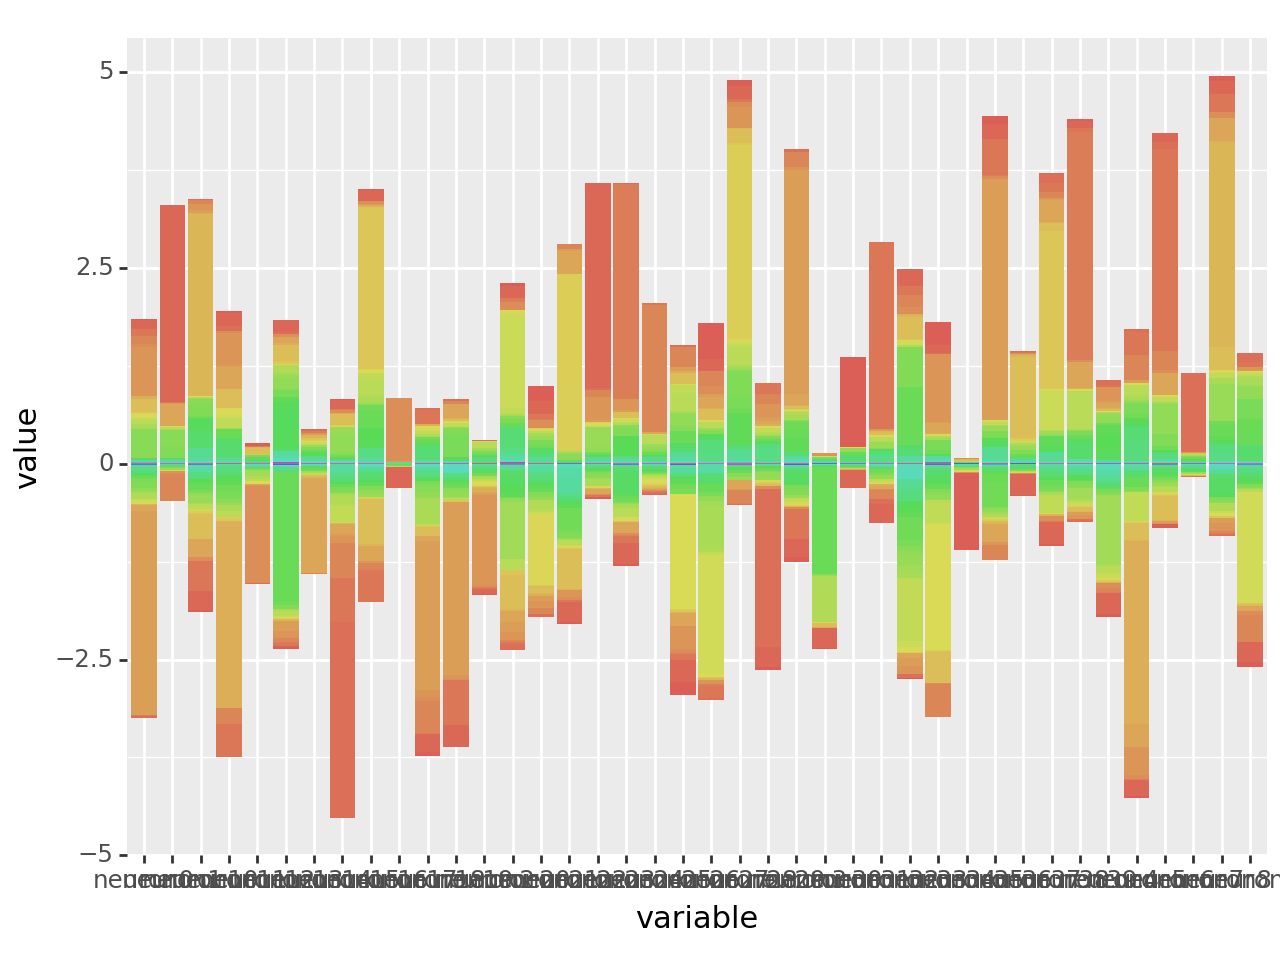

<Figure Size: (640 x 480)>

In [289]:
from plotnine import ggplot, geom_bar, aes

df = w0_df.melt(id_vars=['feature']) # .with_columns(pl.col('importance').log().alias('log_imp'))


ggplot(df, aes(x='variable', y='value', fill='factor(feature)')) + geom_bar(stat='identity', show_legend=False)

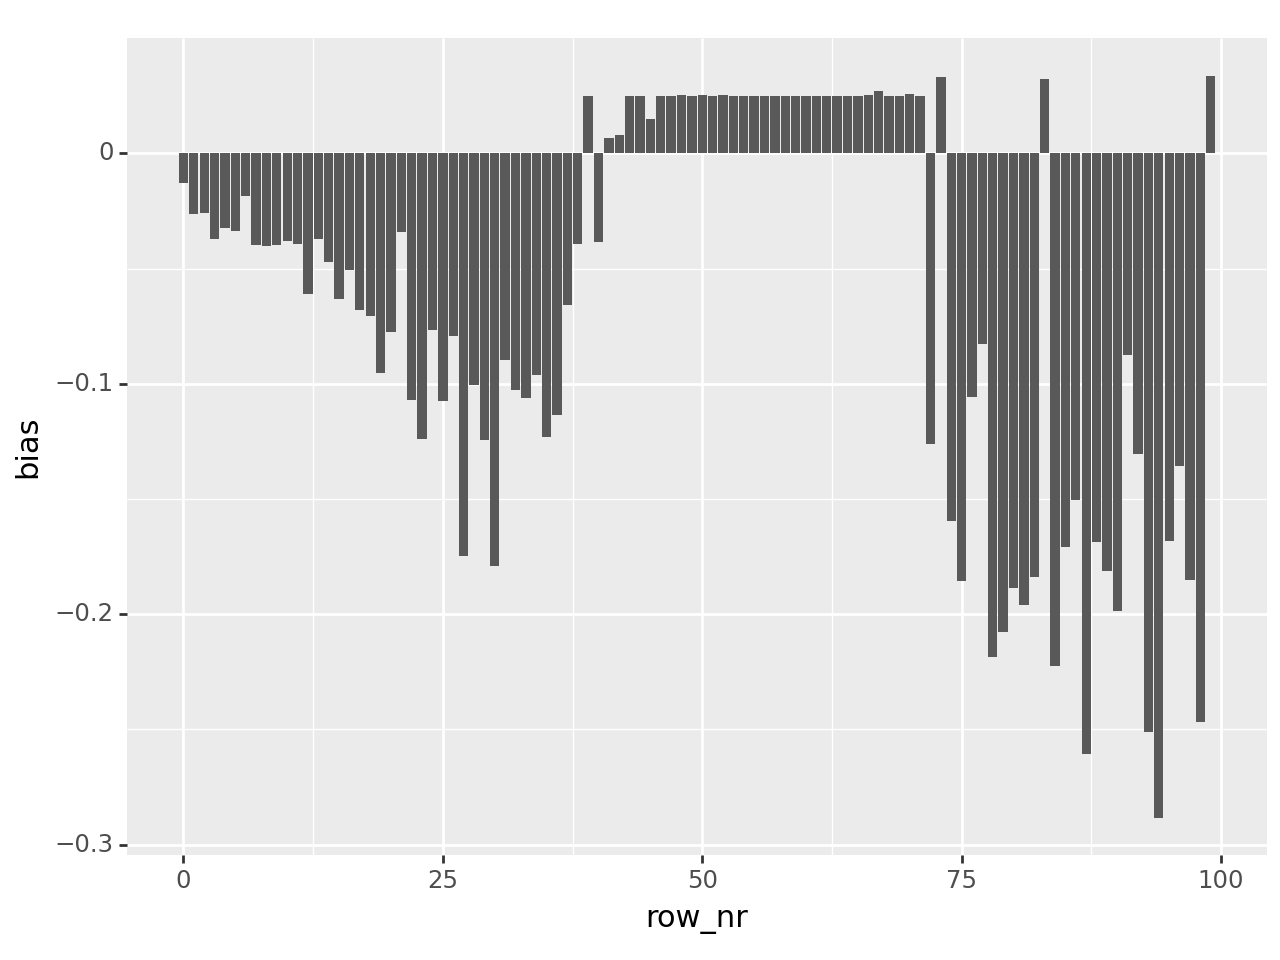

<Figure Size: (640 x 480)>

In [290]:
from plotnine import qplot

biases = pl.DataFrame(model.b1.detach().cpu().numpy(), schema=['bias']).with_row_count()

ggplot(biases, aes(x='row_nr', y='bias')) + geom_bar(stat='identity')

In [291]:

w1_df = (
    pl.DataFrame(model.W1.T.detach().cpu().numpy(), schema=[f'neuron{i}' for i in range(config.n_features)])
    .with_row_count()
    .rename({'row_nr': 'neuron'})
    #.with_columns((0.9 ** pl.col('feature')).alias('importance'))
)

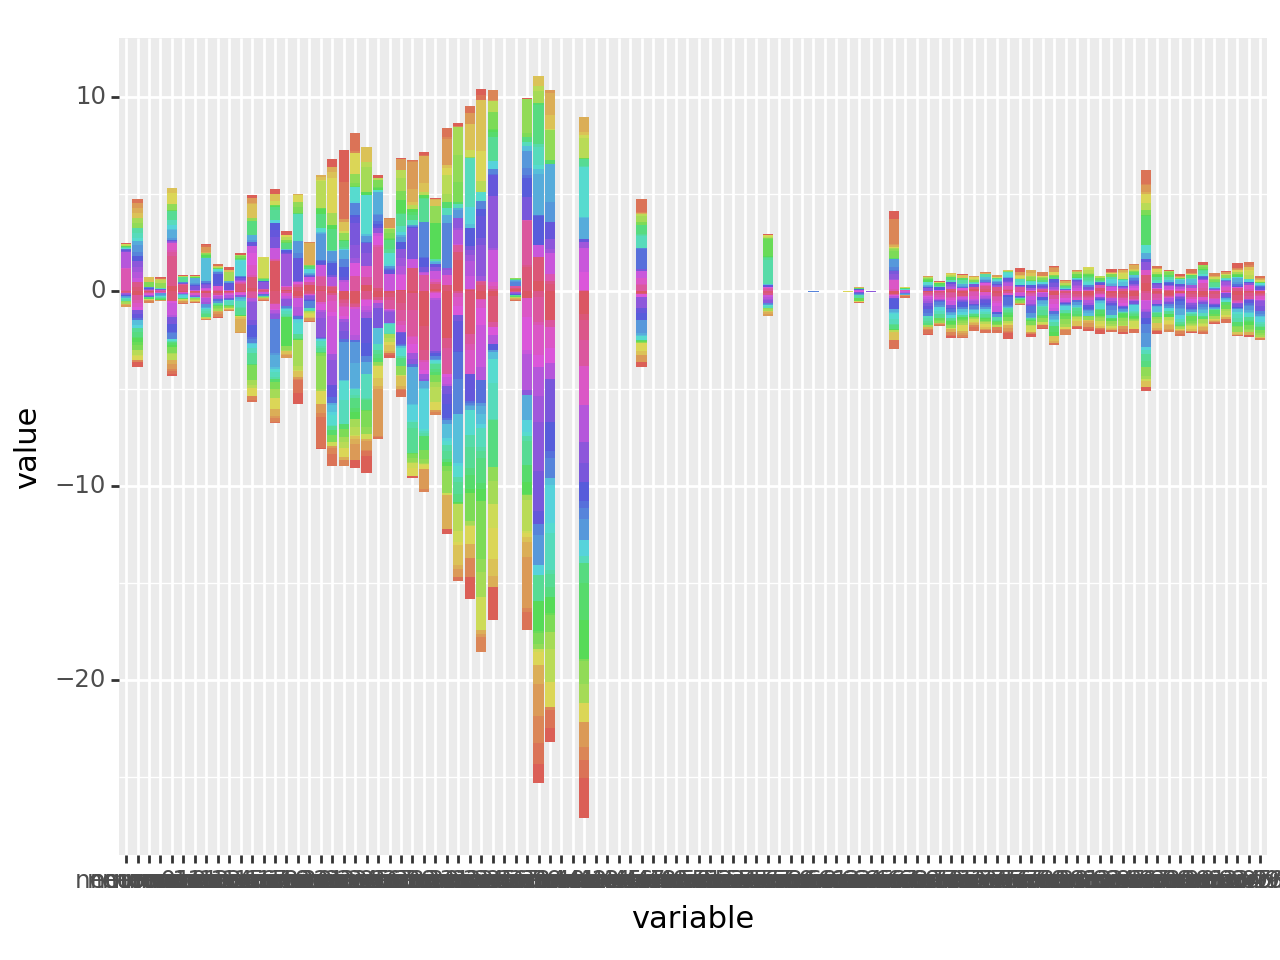

<Figure Size: (640 x 480)>

In [292]:
df = w1_df.melt(id_vars=['neuron']) # .with_columns(pl.col('importance').log().alias('log_imp'))


ggplot(df, aes(x='variable', y='value', fill='factor(neuron)')) + geom_bar(stat='identity', show_legend=False)

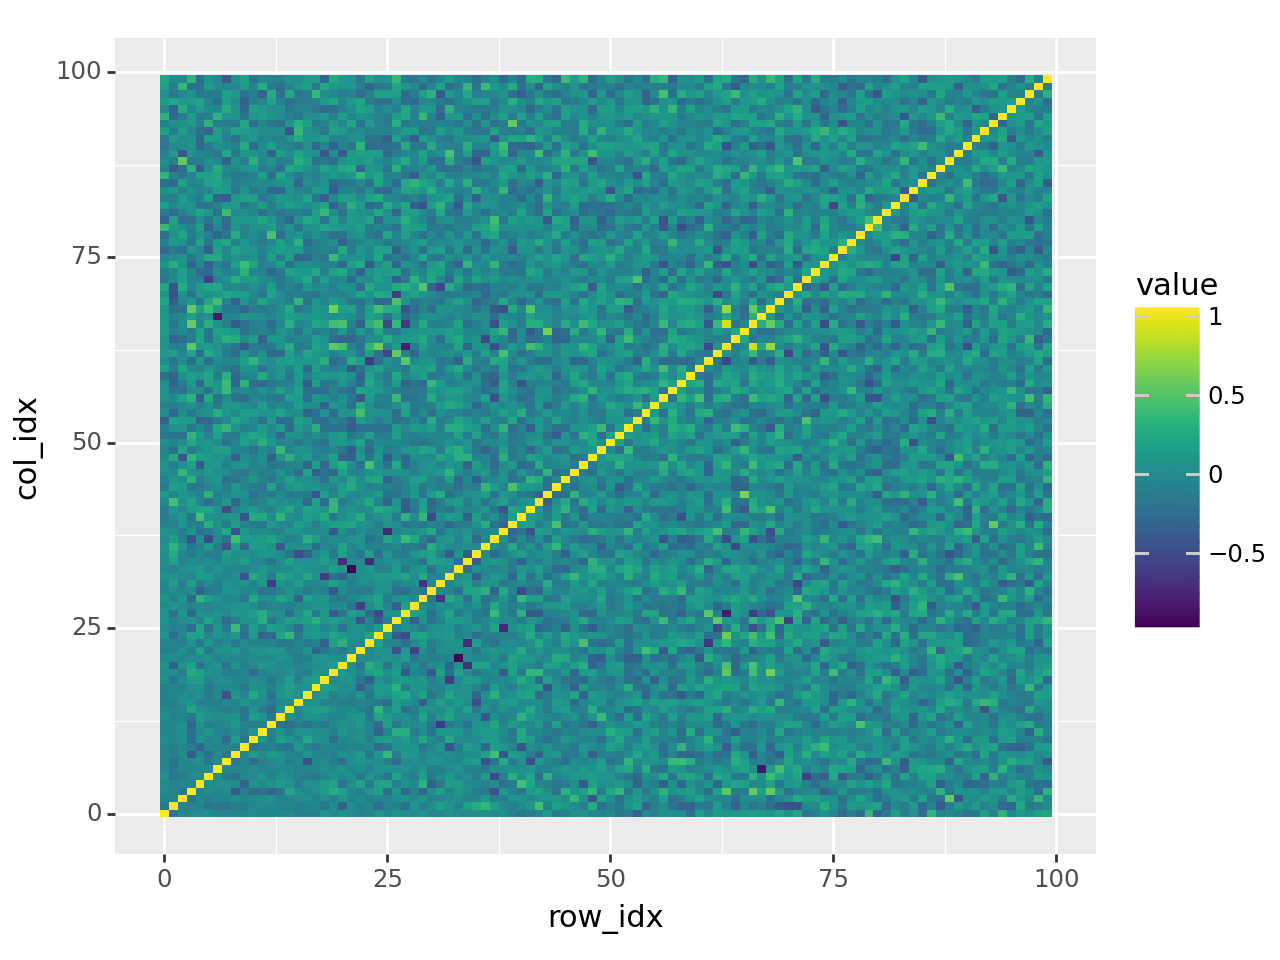

<Figure Size: (640 x 480)>

In [293]:
from plotnine import geom_tile


w1_corr_df = pl.DataFrame(model.W1.corrcoef().detach().cpu().numpy(), schema=[f'{i}' for i in range(100)]).with_row_count().rename({'row_nr': 'row_idx'})
w1_corr_df = w1_corr_df.melt(id_vars='row_idx', variable_name='col_idx').with_columns(pl.col('col_idx').cast(pl.UInt32))
ggplot(w1_corr_df, aes(x='row_idx', y='col_idx', fill='value')) + geom_tile()

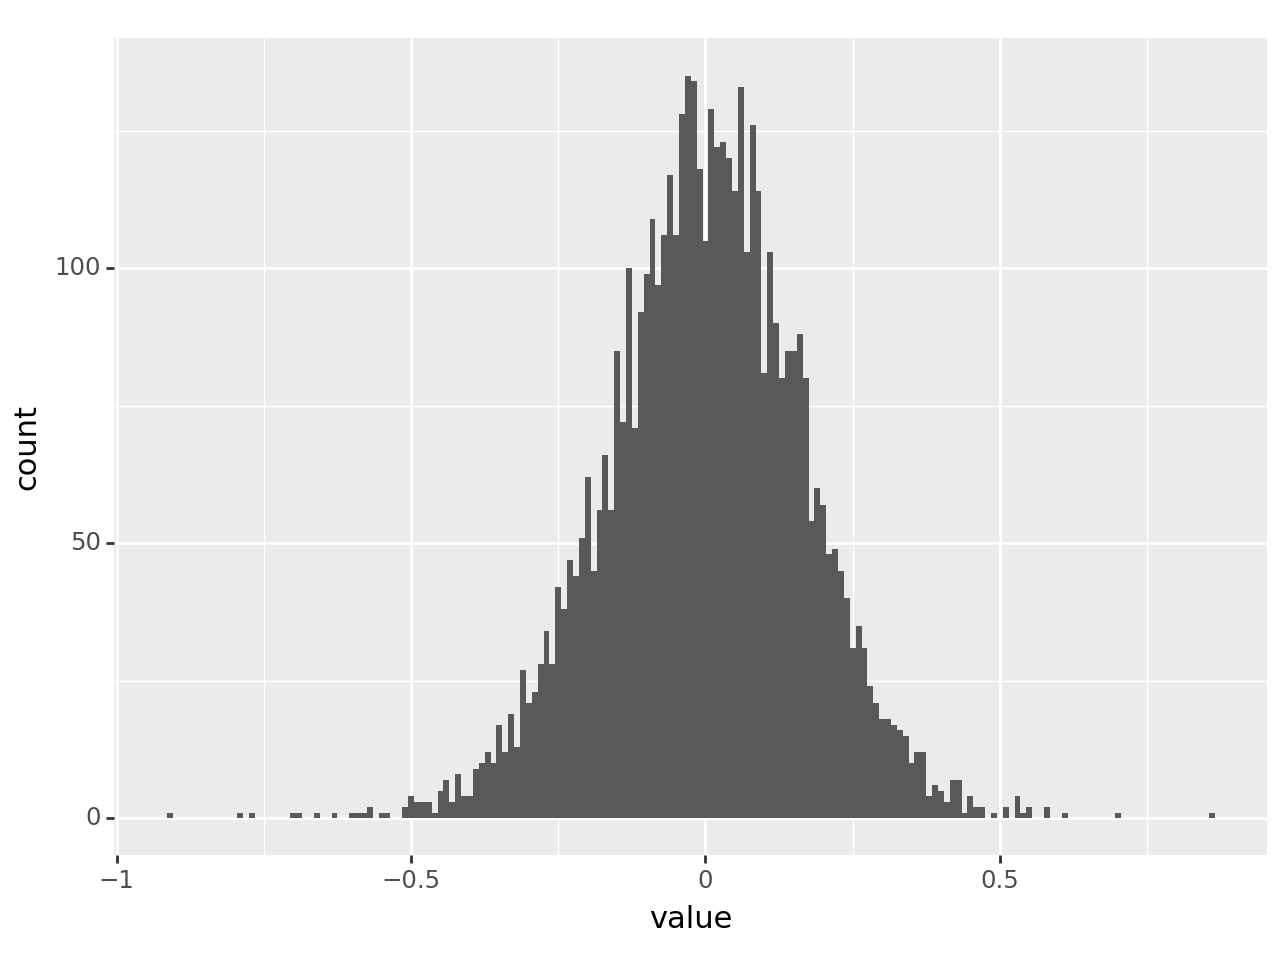

<Figure Size: (640 x 480)>

In [294]:
from plotnine import geom_histogram


ggplot(w1_corr_df.filter(pl.col('row_idx') < pl.col('col_idx')), aes(x='value')) + geom_histogram(binwidth=0.01)

In [295]:
w1_corr_df.filter(pl.col('row_idx') < pl.col('col_idx')).filter(pl.col('value') < -0.25).group_by('col_idx').count().sort('count')

col_idx,count
u32,u32
9,1
12,1
22,1
8,1
33,1
20,1
16,1
23,1
30,2


In [89]:
import math


75287520

In [297]:
import optree
from collections import defaultdict

hyperplanes = defaultdict(int)


def get_hyperplanes(tensor):
    return optree.tree_map(
        lambda x: (tuple(torch.where(x.squeeze().abs() <= 1.0e-5)[0].detach().cpu().tolist()), x.detach().cpu()),
        tensor.split(1)
    )


rounds = 10
for _ in tqdm(range(rounds)):

    data = stream.generate(2**16)
    outs = model(data)
    
    for k, v in get_hyperplanes(outs):
        hyperplanes[k] += 1


  0%|          | 0/10 [00:00<?, ?it/s]

In [298]:
n_hyperplanes = len(list(hyperplanes.keys()))
print(f'{n_hyperplanes}/{rounds * 2**16} ~ {(1.0 * n_hyperplanes) / (rounds * 2**16)}')

151532/655360 ~ 0.231219482421875


In [299]:
class HyperplaneNode:

    def __init__(self, hyperplane_indices: tuple[int], full_dim: int, count=0):
        self.idx = tuple(sorted(hyperplane_indices))
        self.hp_set = set(self.idx)
        self.dim = len(self.idx)
        self.codim = full_dim - self.dim
        self.full_dim = full_dim
        self.count = 0

    def __eq__(self, other):
        if self.full_dim != other.full_dim:
            raise ValueError('Can only compare hyperplanes in same ambient space.')
        return (self.idx == other.idx) 

    def __lt__(self, other):
        if self.full_dim != other.full_dim:
            raise ValueError('Can only compare hyperplanes in same ambient space.')
        return self.hp_set < other.hp_set

    def __gt__(self, other):
        if self.full_dim != other.full_dim:
            raise ValueError('Can only compare hyperplanes in same ambient space.')
        return self.hp_set < other.hp_set

    def __lte__(self, other):
        if self.full_dim != other.full_dim:
            raise ValueError('Can only compare hyperplanes in same ambient space.')
        return self.hp_set <= other.hp_set

    def __gte__(self, other):
        if self.full_dim != other.full_dim:
            raise ValueError('Can only compare hyperplanes in same ambient space.')
        return self.hp_set <= other.hp_set
        
    

In [128]:
hyperplanes = defaultdict(int)


def get_hyperplanes(tensor):
    return optree.tree_map(
        lambda x: (tuple(torch.where(x.squeeze().abs() <= 1.0e-5)[0].detach().cpu().tolist()), x.detach().cpu()),
        tensor.split(1)
    )


rounds = 50
for _ in tqdm(range(rounds)):

    data = stream.generate(2**16)
    outs = relu(torch.einsum('bf,nf->bn', data, model.W0))
    
    for k, v in get_hyperplanes(outs):
        hyperplanes[k] += 1

  0%|          | 0/50 [00:00<?, ?it/s]

In [300]:

data = torch.vstack([torch.eye(100, device='cuda'), -1 * torch.eye(100, device='cuda')])

outs = relu(torch.einsum('bf,nf->bn',data, model.W0))
intersections = ((outs > 0.0).logical_not()).to(torch.float32)

In [301]:
intersections.sum(dim=1).min()

tensor(10., device='cuda:0')

In [302]:
comp = intersections @ intersections.T

In [303]:
#torch.where((comp - comp.diag().unsqueeze(1)) == 0)
comp

tensor([[23., 18.,  4.,  ..., 14., 10., 12.],
        [18., 21.,  5.,  ..., 11.,  9., 12.],
        [ 4.,  5., 16.,  ...,  8.,  9.,  9.],
        ...,
        [14., 11.,  8.,  ..., 20.,  9., 10.],
        [10.,  9.,  9.,  ...,  9., 19., 11.],
        [12., 12.,  9.,  ..., 10., 11., 22.]], device='cuda:0')

In [304]:
((comp - comp.diag().unsqueeze(1)) == 0).sum(dim=1).argmax()


tensor(0, device='cuda:0')

In [317]:
x = torch.zeros((2, 100), device='cuda')
x[0, 1] = 1.0
x[1, 1] = -1.0
outs = relu(torch.einsum('bf,nf->bn', x, model.W0))
outs.sum(0)

tensor([1.1794e-01, 2.5147e+00, 6.3764e-02, 2.3478e-01, 2.7004e-01, 2.1228e-01,
        1.1881e-01, 3.5388e-03, 1.7648e-01, 2.5095e-01, 2.3370e-01, 1.7069e-01,
        7.0962e-03, 1.5999e-01, 7.1826e-03, 1.1014e-01, 1.3429e-01, 2.6483e-01,
        2.4053e-01, 2.8341e-01, 1.4958e-01, 1.5674e-01, 2.6048e-01, 2.6232e+00,
        2.6974e-01, 7.8897e-03, 2.7183e-01, 1.6392e-01, 1.7163e-01, 2.5340e-01,
        2.4693e-01, 2.3565e-01, 2.4678e-01, 2.1678e-01, 1.0128e-01, 2.2888e-03,
        1.8963e-01, 2.6437e-01, 2.8667e-01, 9.1850e-02], device='cuda:0',
       grad_fn=<SumBackward1>)

In [327]:
relu((model.W1 @ torch.rand((40,), device='cuda')) + model.b1)

tensor([0.0123, 0.8463, 0.1749, 0.4533, 0.1773, 0.0000, 1.2195, 0.7208, 0.1658,
        1.4712, 0.1438, 0.1311, 0.1722, 0.0000, 0.2118, 0.9020, 0.1755, 0.3416,
        0.1883, 0.0000, 0.0000, 0.0000, 0.0000, 0.2032, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1104, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0234, 0.0000, 0.0000, 0.0000, 0.0233, 0.0245,
        0.0000, 0.0246, 0.0257, 0.0257, 0.0230, 0.0250, 0.0252, 0.0259, 0.0259,
        0.0255, 0.0248, 0.0241, 0.0252, 0.0255, 0.0246, 0.0253, 0.0253, 0.0259,
        0.0230, 0.0256, 0.0247, 0.0247, 0.0000, 0.0095, 0.0252, 0.0000, 0.0249,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0', grad_fn=<ReluBackward0>)

In [326]:
(comp.diag() == 90).sum()

tensor(0, device='cuda:0')

/home/dashiell/workspace/superposition/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 456'. Pick better value with 'binwidth'.


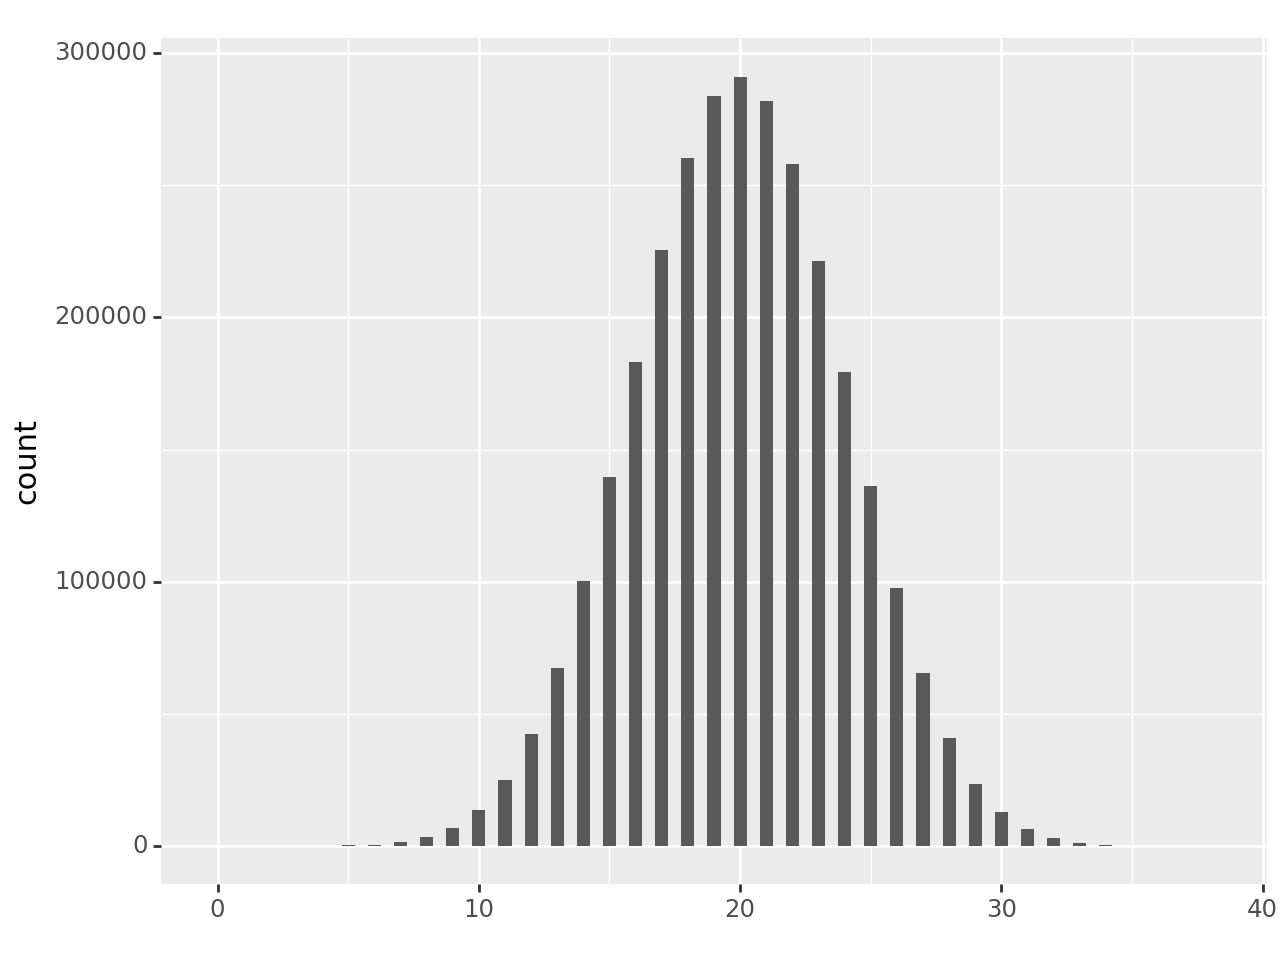

<Figure Size: (640 x 480)>

In [129]:
from plotnine import qplot

qplot([40 - len(k) for k in hyperplanes.keys()]) + geom_histogram(binwidth=0.5)

In [130]:
off_dist_hyperplanes = defaultdict(int)

rounds = 10
for _ in tqdm(range(rounds)):

    data = torch.randn((2**16, 100), device='cuda')
    outs = relu(torch.einsum('bf,nf->bn', data, model.W0))
    
    for k, v in get_hyperplanes(outs):
        off_dist_hyperplanes[k] += 1

  0%|          | 0/10 [00:00<?, ?it/s]

/home/dashiell/workspace/superposition/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 207'. Pick better value with 'binwidth'.


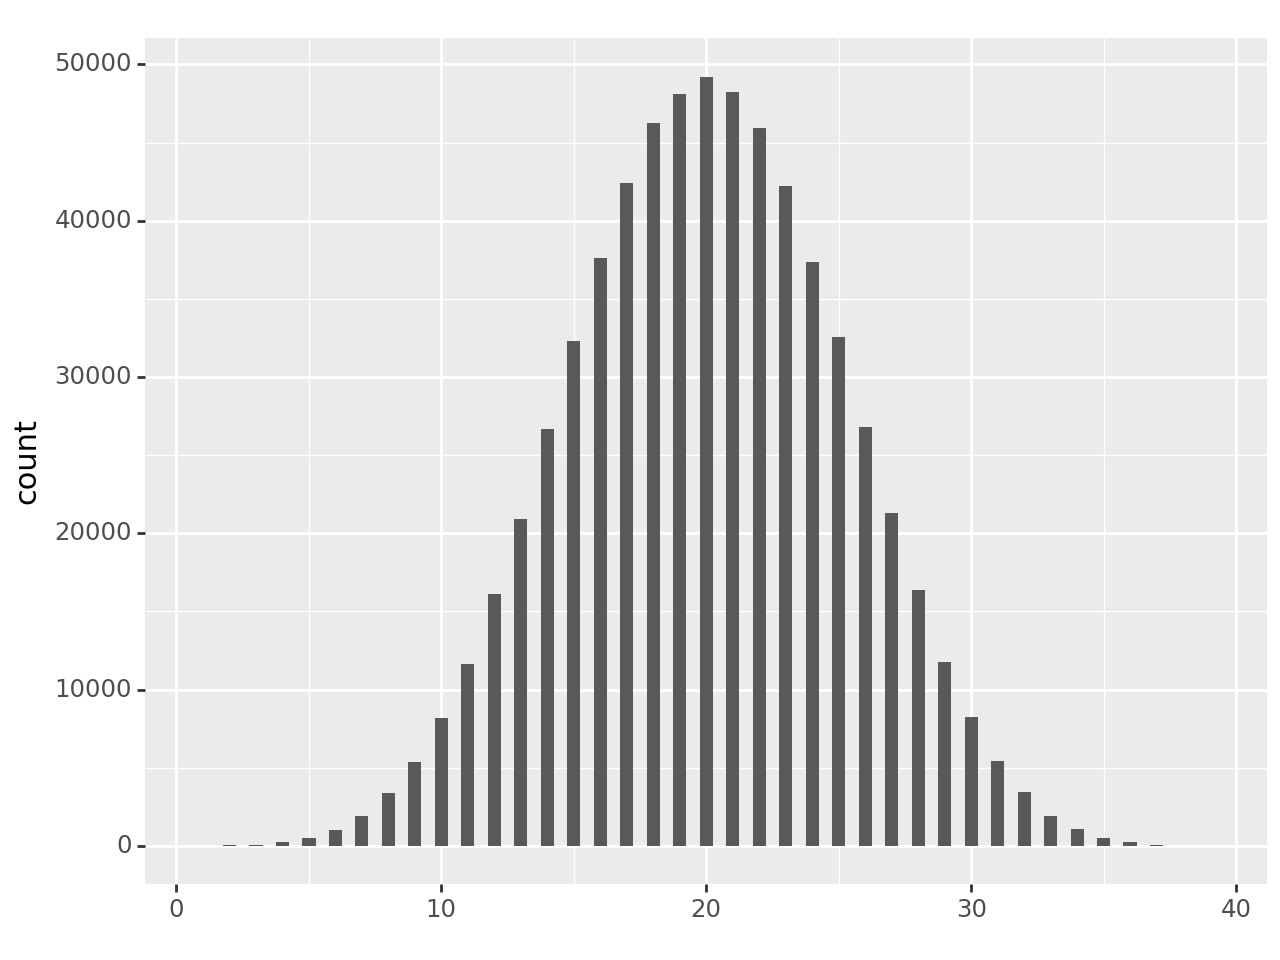

<Figure Size: (640 x 480)>

In [131]:
qplot([40 - len(k) for k in off_dist_hyperplanes.keys()]) + geom_histogram(binwidth=0.5)

In [135]:
x0 = torch.zeros((100,), device='cuda')
x0[0] = 0.5

relu(model.W0 @ x0)

tensor([1.1657e-04, 0.0000e+00, 1.3579e-03, 6.9847e-03, 0.0000e+00, 6.0254e-03,
        6.4780e-03, 0.0000e+00, 1.7181e-03, 0.0000e+00, 2.6452e-05, 7.0777e-04,
        1.0229e-04, 3.1328e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.1501e-04, 9.4836e-04, 1.5258e-02, 0.0000e+00, 3.3404e-03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6224e-04, 0.0000e+00, 8.8131e-06,
        1.2913e-02, 1.2801e-04, 5.4401e-04, 3.6239e-04, 7.0544e-05, 0.0000e+00,
        1.1930e-04, 0.0000e+00, 2.9517e-04, 6.5997e-04], device='cuda:0',
       grad_fn=<ReluBackward0>)

In [47]:
import rustworkx as rx

G = rx.PyDiGraph()

root = G.add_node(HyperplaneNode((), 100))
G.add_children


0

In [48]:
planes = sorted(hyperplanes.keys(), key = lambda x: (len(x), x))

In [52]:
hyperplanes[planes[4]]

1

In [132]:
math.comb(40, 20)

137846528820

In [119]:
import math
math.comb(40, 4)

91390

/home/dashiell/workspace/superposition/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 210'. Pick better value with 'binwidth'.


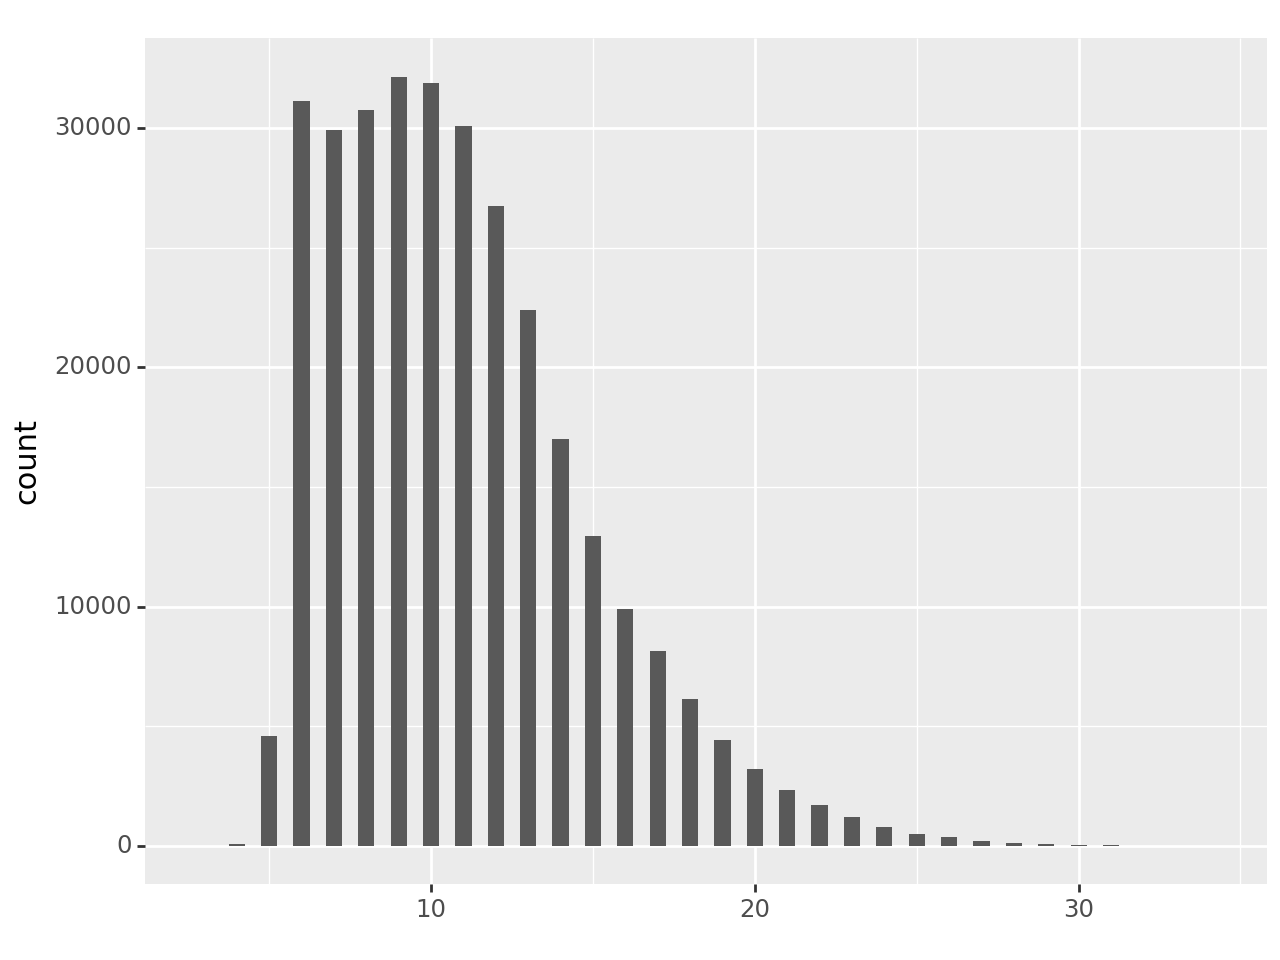

<Figure Size: (640 x 480)>

In [121]:
from plotnine import qplot

qplot([100 - len(k) for k in hyperplanes.keys()]) + geom_histogram(binwidth=0.5)

In [116]:
qplot([len(v) for v in hyperplanes.values()]) + geom_histogram(binwidth=0.5)

/home/dashiell/workspace/superposition/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 1142'. Pick better value with 'binwidth'.

KeyboardInterrupt



In [23]:
for i in rows.unique():
    print(torch.where(rows == i))
    print(cols[torch.where(rows == i)])

(tensor([0]),)
tensor([1])
(tensor([1]),)
tensor([3])
(tensor([2, 3]),)
tensor([0, 4])
(tensor([4, 5, 6]),)
tensor([1, 2, 4])


In [11]:
from plotnine import geom_histogram

preacts = pl.DataFrame(torch.einsum('bf,nf->bn', stream.generate(1000), model.W0).detach().cpu().numpy(), schema=[str(i) for i in range(40)])
df = preacts.melt()

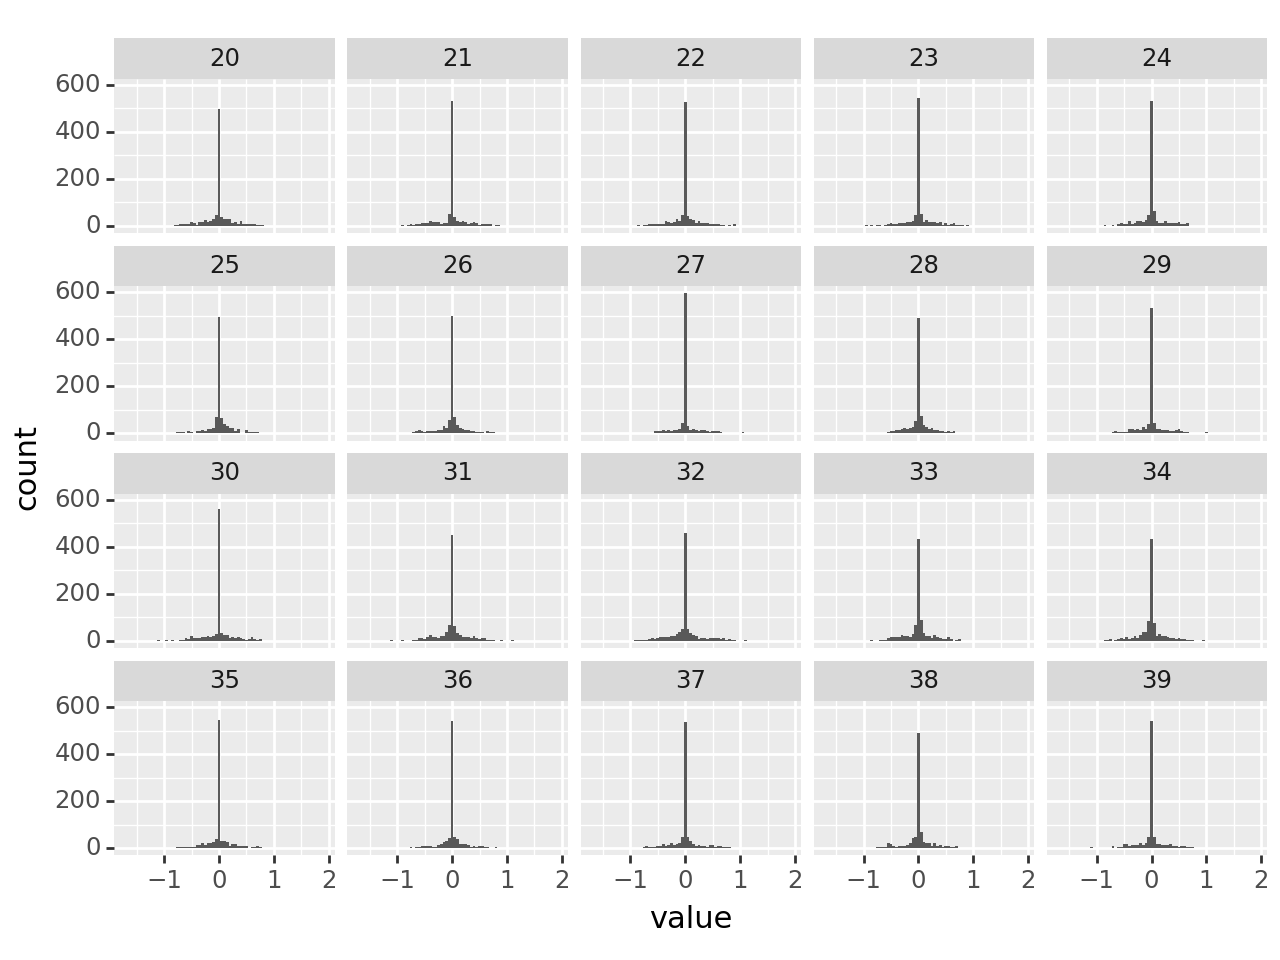

<Figure Size: (640 x 480)>

In [12]:
ggplot(df.filter((pl.col('variable').cast(pl.Int32) > 19) & (pl.col('variable').cast(pl.Int32) < 40)), aes(x='value')) + geom_histogram(binwidth=0.05) + facet_wrap('~variable')

In [13]:
data = stream.generate(10000)

torch.where(torch.einsum('bf,nf->bn', data, model.W0).abs() < 1.e-5)

(tensor([  15,   15,   35,  ..., 9954, 9954, 9954], device='cuda:0'),
 tensor([15, 34, 27,  ..., 37, 38, 39], device='cuda:0'))

In [228]:
data[51]

tensor([ 0.2268,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.9337,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -0.8630,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.4115,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.84

In [230]:
data[31]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.7064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6968, 0.0000, 0.0000, 0.8869,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0')

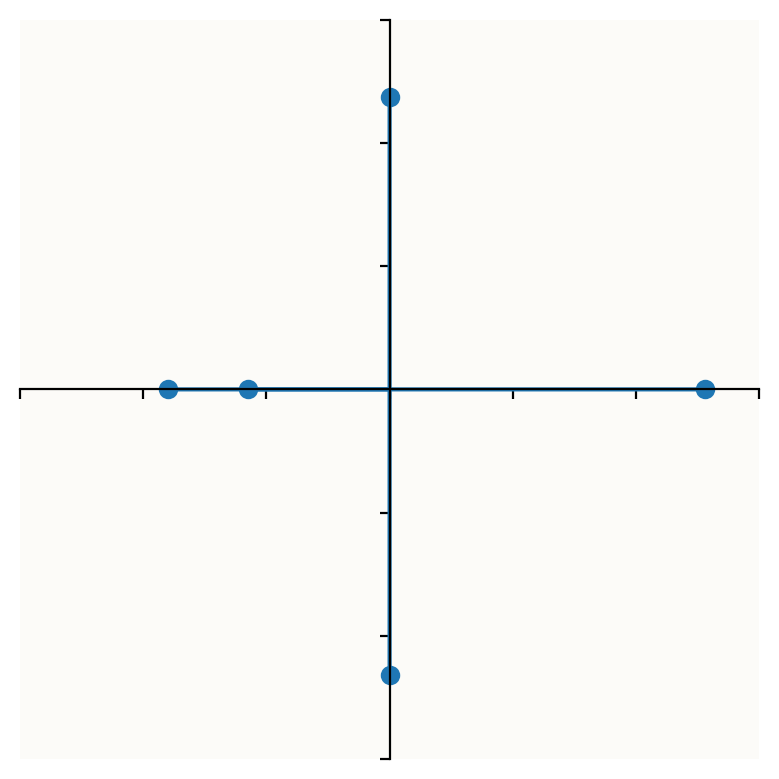

In [60]:
from matplotlib import colors  as mcolors
from matplotlib import collections  as mc

def plot_intro_diagram(model, stream):

    cfg = model.config
    W0_A = model.linear0.weight
    W1_A = model.linear1.weight
    N = len(W0_A[:,0])
    sel = range(config.n_instances) # can be used to highlight specific sparsity levels
    #plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(stream.importance.cpu().numpy()))
    plt.rcParams['figure.dpi'] = 200
    fig, ax = plt.subplots()

    W = W0_A.cpu().detach().numpy()
    #colors = [mcolors.to_rgba(c)
    #    for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
    #ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
    ax.scatter(W[:,0], W[:,1])
    ax.set_aspect('equal')
    #ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))
    ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1)))
    
    z = 1.5
    ax.set_facecolor('#FCFBF8')
    ax.set_xlim((-z,z))
    ax.set_ylim((-z,z))
    ax.tick_params(left = True, right = False , labelleft = False ,
              labelbottom = False, bottom = True)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom','left']:
        ax.spines[spine].set_position('center')
    plt.show()

plot_intro_diagram(model, stream)

In [53]:
W = W0_A.cpu().detach().numpy()
W

array([[-3.3558461e-01, -7.0413970e-04],
       [ 1.0101963e-04,  9.9034435e-01],
       [ 3.1240564e-04, -7.4370539e-01],
       [-1.1632881e+00,  8.4953579e-05],
       [ 1.2330844e+00, -1.3950655e-04]], dtype=float32)

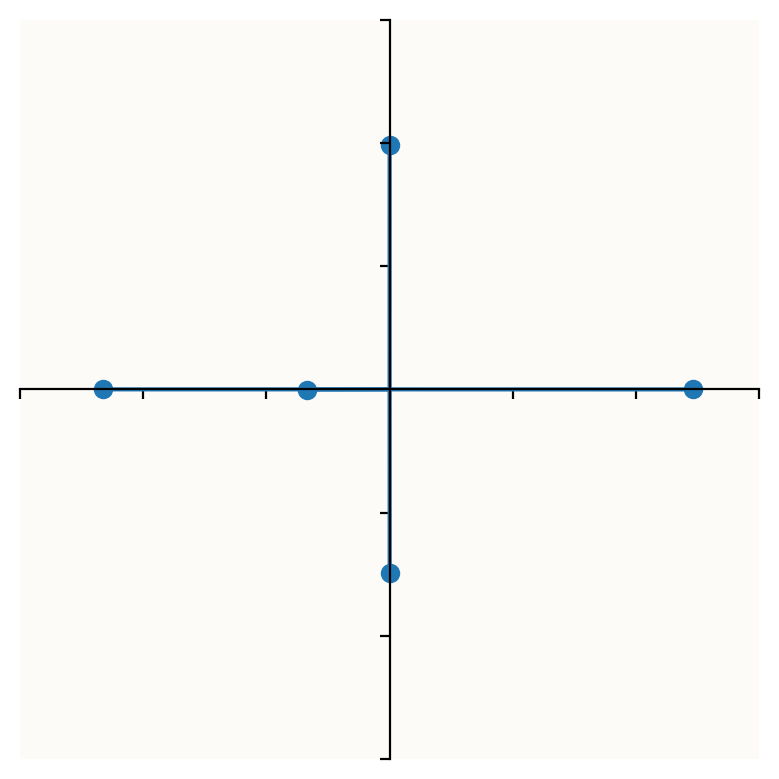

In [52]:
cfg = model.config
W0_A = model.linear0.weight
W1_A = model.linear1.weight
N = len(W0_A[:,0])
sel = range(config.n_instances) # can be used to highlight specific sparsity levels
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(stream.importance.cpu().numpy()))
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots()

W = W0_A.cpu().detach().numpy()
#colors = [mcolors.to_rgba(c)
#    for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
#ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
ax.scatter(W[:,0], W[:,1])
ax.set_aspect('equal')
#ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))
ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1)))

z = 1.5
ax.set_facecolor('#FCFBF8')
ax.set_xlim((-z,z))
ax.set_ylim((-z,z))
ax.tick_params(left = True, right = False , labelleft = False ,
          labelbottom = False, bottom = True)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom','left']:
    ax.spines[spine].set_position('center')
plt.show()

In [34]:
W

array([[ 1.1052375e+00, -7.9472713e-02],
       [ 1.9320844e-01, -1.0739383e+00],
       [-9.9909025e-01, -4.6647742e-01],
       [ 2.8025672e-02, -2.2381398e-01],
       [-7.2942275e-01,  7.8876936e-01],
       [-9.5745077e-04,  1.6257060e-03],
       [-1.3350666e-04, -4.6174368e-04],
       [ 3.9898586e-01,  9.2390126e-01]], dtype=float32)

In [22]:
from torch.func import functional_call, stack_module_state
import copy

config = Config(
    n_features = 20,
    n_hidden = 10,
    n_instances = 1,
)

device = 'cuda:0'

model = Model(
    config=config,
    # Exponential feature importance curve from 1 to 1/100
    #importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    #feature_probability = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)
model.to(device)

#models = [Model(config).to(device) for _ in range(config.n_instances)]

stream = SparseUniformData(
    config.n_instances,
    config.n_features,
    # Exponential feature importance curve from 1 to 1/100
    #importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = torch.tensor(0.2)   #(20 ** -torch.linspace(0, 1, config.n_instances))[:, None, None]
)

#base_model = copy.deepcopy(models[0])
#base_model = base_model.to('meta')

#def fmodel(params, x):
#    return functional_call(base_model, (params,), (x,))
model(stream.generate(2))